In [1]:
import numpy as np
import scipy as sp
import math
import torch
import matplotlib.pyplot as plt
import inspect
import textwrap

from typing import Callable
from torch import nn, optim
from data import diffeq, create_trainig_test_set

import torch.nn.functional as F

In [2]:
#Define the harmonic oscillator

def f(t,x,k):
    #write the function that is on the other side of the differential equation
    return -k*x

def differential_equation_1_order(t, x, k):
    dx_dt = f(t,x,k)
    return dx_dt

def differential_equation_2_order(t, X, k):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,k)

    return [dx_dt, dy_dt]

In [4]:
torch.manual_seed(0) #get the same random numbers everytime you run the code

t_span = (0, 10)
n_step = 100
n_data = 1000
coeff_test = 0.3

cooling_deq = diffeq(differential_equation_2_order, 2, 1)

train, test = create_trainig_test_set(cooling_deq, t_span, n_step, n_data, coeff_test, "RK45")
print(train["X"][0].shape)
in_features = train["X"][0].shape[0]

torch.Size([103])


In [5]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
    print(device)

In [6]:
class CoolingModel(nn.Module):
    def __init__(self, n_step):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.fc2 = nn.Linear(32, n_step)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))     # smooth activation
        x = self.fc2(x)
        return x

# Initiate the model
model = CoolingModel(n_step)

In [7]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) #updates model parameters based on the gradients computed from the loss

In [8]:
epochs = 10000

for epoch in range(epochs):
    T_pred = model(train["X"])
    
    loss = loss_func(T_pred, train["y_tensor"][0:, 0])

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    if (epoch+1) % (int(epochs/100)) == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 100/10000, Loss: 0.7714
Epoch 200/10000, Loss: 0.7280
Epoch 300/10000, Loss: 0.6234
Epoch 400/10000, Loss: 0.5617
Epoch 500/10000, Loss: 0.5406
Epoch 600/10000, Loss: 0.5290
Epoch 700/10000, Loss: 0.5199
Epoch 800/10000, Loss: 0.5110
Epoch 900/10000, Loss: 0.5014
Epoch 1000/10000, Loss: 0.4907
Epoch 1100/10000, Loss: 0.4777
Epoch 1200/10000, Loss: 0.4691
Epoch 1300/10000, Loss: 0.4466
Epoch 1400/10000, Loss: 0.4307
Epoch 1500/10000, Loss: 0.4071
Epoch 1600/10000, Loss: 0.3851
Epoch 1700/10000, Loss: 0.3647
Epoch 1800/10000, Loss: 0.3468
Epoch 1900/10000, Loss: 0.3309
Epoch 2000/10000, Loss: 0.3168
Epoch 2100/10000, Loss: 0.2996
Epoch 2200/10000, Loss: 0.2865
Epoch 2300/10000, Loss: 0.2779
Epoch 2400/10000, Loss: 0.2636
Epoch 2500/10000, Loss: 0.2550
Epoch 2600/10000, Loss: 0.2493
Epoch 2700/10000, Loss: 0.2296
Epoch 2800/10000, Loss: 0.2176
Epoch 2900/10000, Loss: 0.2057
Epoch 3000/10000, Loss: 0.1930
Epoch 3100/10000, Loss: 0.1818
Epoch 3200/10000, Loss: 0.1718
Epoch 3300/10000,

In [9]:
model.eval()
with torch.no_grad():
    T_pred_test = model(test["X"])
    print(T_pred_test)
    test_loss = loss_func(T_pred_test, test["y_tensor"][0:, 0])
    print(f"Test Loss: {test_loss.item():.4f}")

tensor([[ 1.0096,  1.0580,  1.1033,  ..., -0.7891, -0.7530, -0.7216],
        [ 0.1681,  0.2438,  0.3177,  ...,  0.8310,  0.8109,  0.7858],
        [ 0.3826,  0.4356,  0.4883,  ...,  1.3749,  1.3279,  1.2807],
        ...,
        [ 0.7246,  0.7365,  0.7456,  ...,  0.4202,  0.4421,  0.4595],
        [ 0.8754,  0.8999,  0.9199,  ...,  0.9122,  0.8944,  0.8713],
        [ 0.2632,  0.2720,  0.2797,  ...,  0.3948,  0.4096,  0.4214]])
Test Loss: 0.0334


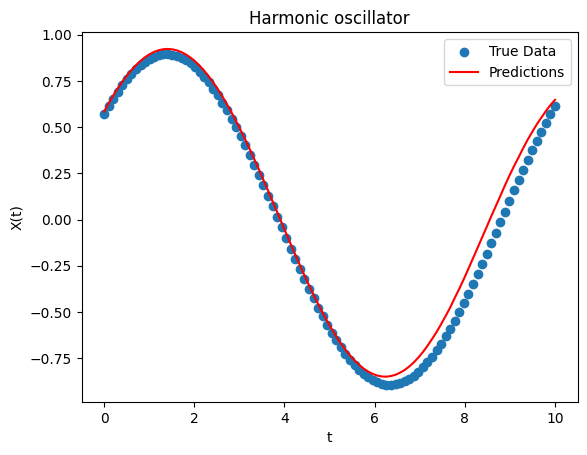

In [10]:
n = 30
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0], label="True Data")
plt.plot(test["t_tensor"][n], T_pred_test[n], color="red", label="Predictions")
plt.xlabel("t")
plt.ylabel("X(t)")
plt.title("Harmonic oscillator")
plt.legend()
plt.show()